## 概要: 役割分担の定量化
prior$(\mu_p, \sigma_p)$の入力を25秒間入力した時に到達する内部状態を$x_s[(\mu_p, \sigma_p)], x_m[(\mu_p, \sigma_p)]$とする。

ある入力$\mu_l$を入力した際の出力$y$が$x_s[(\mu_p, \sigma_p)], x_m[(\mu_p, \sigma_p)]$を変更したときにそれぞれどの程度の影響を受けるかを調べ、役割分担の定量化とする。

In [2]:
import os
import math

import matplotlib
import numpy as np
import sys
import scipy
import yaml

from sklearn.metrics import mean_squared_error

sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from matplotlib import cm

from slow_reservoir.model import RNN, RNNTrainableAlpha
from slow_reservoir.dataset.dynamic_state import State

%matplotlib inline

In [3]:
sigma_sq = 0.5

In [4]:
def make_signal_for_prior(time_length, mu_p, sigma_p, uncertainty=0.5, g=1.25):
    input_signals = np.zeros([1, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    
    state = State(mu=mu_p, sigma=sigma_p)
    
    for i in range(1):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            true_signal = state()
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            
            signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        
    return input_signals


def make_sample_signal(signal_mu, batch_size, g=1.25):
    input_signals = np.zeros([batch_size, 1, 100])
    phi = np.linspace(-2, 2, 100)
    
    signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
    for i in range(batch_size):
        input_signals[i, 0] = np.random.poisson(signal_base)
        
    return input_signals

In [5]:
config_path = \
    '../slow_reservoir/trained_model/dynamic_state_random/20220526_1_stable/20220526_1_stable.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()



model_name:  20220526_1_stable


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [6]:
model.alpha_slow[0].item()

1.0

In [7]:
mu_p_list = np.linspace(-0.5, 0.5, 50)
sigma_p_list = np.linspace(0.01, 0.8, 50)

$x_s[(\mu_p, \sigma_p)], x_m[(\mu_p, \sigma_p)]$の算出

In [8]:
"""
sigma_l = math.sqrt(1/1.25) * 0.5

neural_states = np.zeros((50, 50, 200))
reservoir_states = np.zeros((50, 50, 50))
for i in range(50):
    for j in range(50):
    # mu_p = np.random.rand()-0.5
    # sigma_p = np.random.rand()*0.8
    # mu_p_list.append(mu_p)
    # sigma_p_list.append(sigma_p)
        mu_p = mu_p_list[i]
        sigma_p = sigma_p_list[j]
        input_signal = make_signal_for_prior(
            time_length=50, 
            mu_p=mu_p,
            sigma_p=sigma_p,
            uncertainty=0.5,
            g=1.25,
        )
        inputs = torch.from_numpy(input_signal).float()                                 
        inputs = inputs.to(device) 
        hidden_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['SIZE']))
        reservoir_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['RESERVOIR']))
         
        hidden = torch.from_numpy(hidden_np).float()                               
        hidden = hidden.to(device) 
        reservoir = torch.from_numpy(reservoir_np).float()
        reservoir = reservoir.to(device)
        hidden_list, _, _, reservoir_list = model(inputs, hidden, reservoir, 50) 
        
        neural_dynamics = hidden_list.cpu().detach().numpy()   
        reservoir_dynamics = reservoir_list.cpu().detach().numpy()
        
        neural_states[i, j] = neural_dynamics[0, -1]
        reservoir_states[i, j] = reservoir_dynamics[0, -1]
        
"""

"\nsigma_l = math.sqrt(1/1.25) * 0.5\n\nneural_states = np.zeros((50, 50, 200))\nreservoir_states = np.zeros((50, 50, 50))\nfor i in range(50):\n    for j in range(50):\n    # mu_p = np.random.rand()-0.5\n    # sigma_p = np.random.rand()*0.8\n    # mu_p_list.append(mu_p)\n    # sigma_p_list.append(sigma_p)\n        mu_p = mu_p_list[i]\n        sigma_p = sigma_p_list[j]\n        input_signal = make_signal_for_prior(\n            time_length=50, \n            mu_p=mu_p,\n            sigma_p=sigma_p,\n            uncertainty=0.5,\n            g=1.25,\n        )\n        inputs = torch.from_numpy(input_signal).float()                                 \n        inputs = inputs.to(device) \n        hidden_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['SIZE']))\n        reservoir_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['RESERVOIR']))\n         \n        hidden = torch.from_numpy(hidden_np).float()                               \n        hidden = hidden.to(device) \n        re

$\mu_l=0$の入力が$x_s[(\mu_p, \sigma_p)], x_m[(\mu_p, \sigma_p)]$のもとどのような出力になるのか検証

In [9]:
"""
input_signal = make_sample_signal(0, 1)
output_array = np.zeros((50, 50))
inputs = torch.from_numpy(input_signal).float().to(device)

for i in range(50):
    for j in range(50):
        hidden = torch.from_numpy(neural_states[i, j]).float().to(device)
        reservoir = torch.from_numpy(reservoir_states[i, j]).float().to(device)

        _, output_list, _, _ = model(inputs, hidden, reservoir, 1) 
        
        output_array[j, i] = output_list[0, 0, 0].detach().item()
"""

'\ninput_signal = make_sample_signal(0, 1)\noutput_array = np.zeros((50, 50))\ninputs = torch.from_numpy(input_signal).float().to(device)\n\nfor i in range(50):\n    for j in range(50):\n        hidden = torch.from_numpy(neural_states[i, j]).float().to(device)\n        reservoir = torch.from_numpy(reservoir_states[i, j]).float().to(device)\n\n        _, output_list, _, _ = model(inputs, hidden, reservoir, 1) \n        \n        output_array[j, i] = output_list[0, 0, 0].detach().item()\n'

In [10]:
"""
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.view_init(elev=25, azim=80)

x1, x2 = np.meshgrid(mu_p_list, sigma_p_list)
ax.plot_surface(
    x1,
    x2,
    output_array,
)

ax.set_xlabel(r'$\mu_p$', fontsize=14)
ax.set_ylabel(r'$\sigma_p$', fontsize=14)
ax.set_zlabel(r'$y$', fontsize=14)
"""

"\nfig = plt.figure(figsize=(8, 6))\nax = Axes3D(fig)\nax.view_init(elev=25, azim=80)\n\nx1, x2 = np.meshgrid(mu_p_list, sigma_p_list)\nax.plot_surface(\n    x1,\n    x2,\n    output_array,\n)\n\nax.set_xlabel(r'$\\mu_p$', fontsize=14)\nax.set_ylabel(r'$\\sigma_p$', fontsize=14)\nax.set_zlabel(r'$y$', fontsize=14)\n"

In [11]:
sigma_l = math.sqrt(1/1.25) * 0.5

neural_states = np.zeros((500, 200))
reservoir_states = np.zeros((500, 50))

mu_p_list = []
sigma_p_list = []
for i in range(500):
    mu_p = np.random.rand() - 0.5
    sigma_p = np.random.rand() * 0.8
    mu_p_list.append(mu_p)
    sigma_p_list.append(sigma_p)
    input_signal = make_signal_for_prior(
        time_length=50, 
        mu_p=mu_p,
        sigma_p=sigma_p,
        uncertainty=0.5,
        g=1.25,
    )
    inputs = torch.from_numpy(input_signal).float()                                 
    inputs = inputs.to(device) 
    hidden_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['SIZE']))
    reservoir_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['RESERVOIR']))
         
    hidden = torch.from_numpy(hidden_np).float()                               
    hidden = hidden.to(device) 
    reservoir = torch.from_numpy(reservoir_np).float()
    reservoir = reservoir.to(device)
    hidden_list, _, _, reservoir_list = model(inputs, hidden, reservoir, 50) 
        
    neural_dynamics = hidden_list.cpu().detach().numpy()   
    reservoir_dynamics = reservoir_list.cpu().detach().numpy()
        
    neural_states[i] = neural_dynamics[0, -1]
    reservoir_states[i] = reservoir_dynamics[0, -1]

In [12]:
input_signal = make_sample_signal(0, 500)
inputs = torch.from_numpy(input_signal).float().to(device)

hidden = torch.from_numpy(neural_states).float().to(device)
reservoir = torch.from_numpy(reservoir_states).float().to(device)
_, output_list, _, _ = model(inputs, hidden, reservoir, 1) 
        

Text(0.5, 0, '$y$')

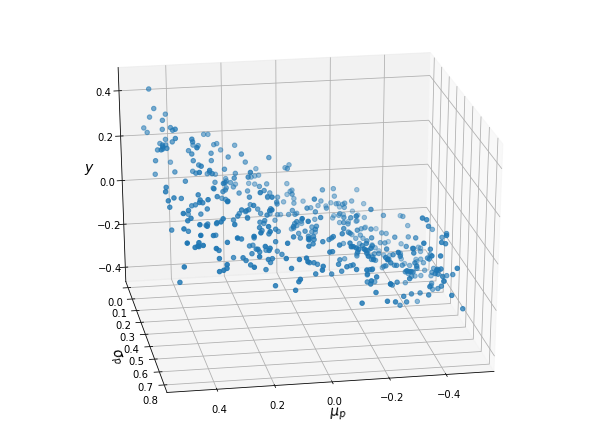

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.view_init(elev=25, azim=80)

ax.scatter(
    mu_p_list,
    sigma_p_list,
    output_list[:, 0, 0].detach().numpy(),
)

ax.set_xlabel(r'$\mu_p$', fontsize=14)
ax.set_ylabel(r'$\sigma_p$', fontsize=14)
ax.set_zlabel(r'$y$', fontsize=14)

In [14]:
np.var(output_list[:, 0, 0].detach().numpy())

0.02489136

$x_s[(0, 0.4)], x_m[(0, 0.4)]$の算出

In [15]:
sigma_l = math.sqrt(1/1.25) * 0.5

input_signal = make_signal_for_prior(
    time_length=50, 
    mu_p=0,
    sigma_p=0.4,
    uncertainty=0.5,
    g=1.25,
)
inputs = torch.from_numpy(input_signal).float()                                 
inputs = inputs.to(device) 
hidden_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['RESERVOIR']))
         
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, _, _, reservoir_list = model(inputs, hidden, reservoir, 50) 
        
base_neural_state = hidden_list.cpu().detach().numpy()[:, -1] 
base_reservoir_state = reservoir_list.cpu().detach().numpy()[:, -1]


In [16]:
input_signal = make_sample_signal(0, 500)
inputs = torch.from_numpy(input_signal).float().to(device)

hidden = torch.from_numpy(base_neural_state).float().to(device)
reservoir = torch.from_numpy(reservoir_states).float().to(device)
_, output_list, _, _ = model(inputs, hidden, reservoir, 1) 


Text(0.5, 0, '$y$')

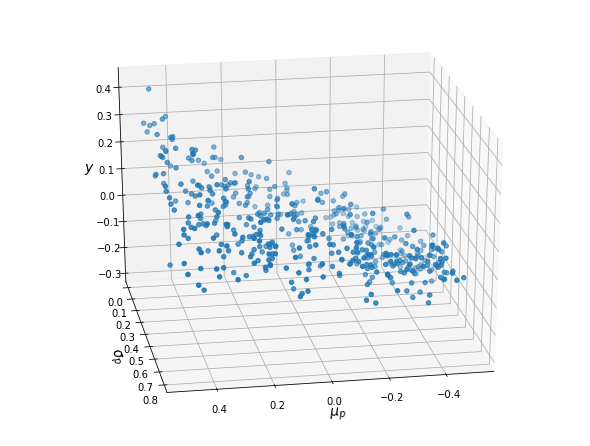

In [17]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.view_init(elev=25, azim=80)

ax.scatter(
    mu_p_list,
    sigma_p_list,
    output_list[:, 0, 0].detach().numpy(),
)

ax.set_xlabel(r'$\mu_p$', fontsize=14)
ax.set_ylabel(r'$\sigma_p$', fontsize=14)
ax.set_zlabel(r'$y$', fontsize=14)

In [18]:
np.var(output_list[:, 0, 0].detach().numpy())

0.013220556

In [19]:
input_signal = make_sample_signal(0, 500)
inputs = torch.from_numpy(input_signal).float().to(device)

hidden = torch.from_numpy(neural_states).float().to(device)
reservoir = torch.from_numpy(base_reservoir_state).float().to(device)
_, output_list, _, _ = model(inputs, hidden, reservoir, 1) 


Text(0.5, 0, '$y$')

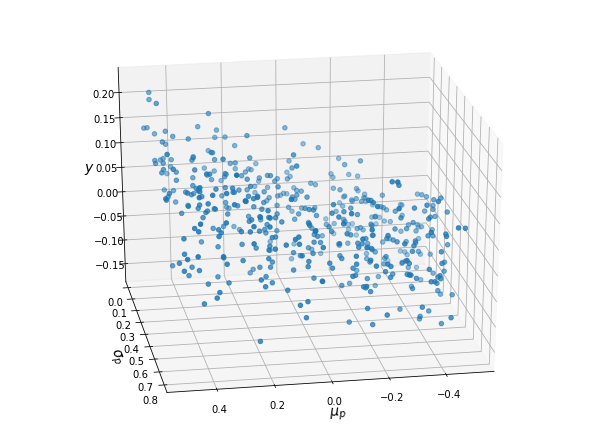

In [20]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.view_init(elev=25, azim=80)

ax.scatter(
    mu_p_list,
    sigma_p_list,
    output_list[:, 0, 0].detach().numpy(),
)

ax.set_xlabel(r'$\mu_p$', fontsize=14)
ax.set_ylabel(r'$\sigma_p$', fontsize=14)
ax.set_zlabel(r'$y$', fontsize=14)

In [21]:
np.var(output_list[:, 0, 0].detach().numpy())

0.0049466724